# MOM6 Global vs MOM6 Regional
This notebook will look at how MOM6 Global compares to MOM6 Regional, as well as observations in the Tasman Sea / EAC domain. 

In [2]:
# load required modules
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy as sci
import dask
import cosima_cookbook as cc
import os
import glob

# Optional modules
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as feature
import xcdat

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

land_50m = feature.NaturalEarthFeature('physical','land','50m',
                                       edgecolor='black',
                                       facecolor='lightgray',
                                       linewidth=0.5)

In [3]:
from dask.distributed import Client
client = Client()
client

2023-02-06 09:49:43,590 [INFO]: scheduler.py(__init__:1615) >> State start
2023-02-06 09:49:43,597 [INFO]: scheduler.py(start_unsafe:3860) >>   Scheduler at:     tcp://127.0.0.1:46167
2023-02-06 09:49:43,598 [INFO]: scheduler.py(start_unsafe:3862) >>   dashboard at:            127.0.0.1:8787
2023-02-06 09:49:43,618 [INFO]: nanny.py(start_unsafe:365) >>         Start Nanny at: 'tcp://127.0.0.1:39247'
2023-02-06 09:49:43,640 [INFO]: nanny.py(start_unsafe:365) >>         Start Nanny at: 'tcp://127.0.0.1:39083'
2023-02-06 09:49:43,649 [INFO]: nanny.py(start_unsafe:365) >>         Start Nanny at: 'tcp://127.0.0.1:33007'
2023-02-06 09:49:43,666 [INFO]: nanny.py(start_unsafe:365) >>         Start Nanny at: 'tcp://127.0.0.1:45233'
2023-02-06 09:49:45,949 [INFO]: scheduler.py(add_worker:4212) >> Register worker <WorkerState 'tcp://127.0.0.1:43525', name: 0, status: init, memory: 0, processing: 0>
2023-02-06 09:49:45,958 [INFO]: scheduler.py(handle_worker:5468) >> Starting worker compute stream,

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46167,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:43525,Total threads: 1
Dashboard: /proxy/38295/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:39247,


## Approach:
Now there are many different ways we could compare the output from one simulation to another, and MOM6 has its own in-built diagnostics that could potentially be used for this. I think something that is highly relevant in our case such as Sea Surface temperature could be a good starting point. We have to acknowledge however that this variable is strongly coupled to the atmospheric forcing, and hence we might expect less intrinsic variability in comparison to say the temperature at the sea floor. 

We'll also have to decide on a point at which the models have been substantially spun up. Overall, I anticipate quite a lot of exploration and testing, meaning that this notebook will become very messy and a bit hard to follow. Perhaps consistent styled headings will be the best approach to make things a little more readable. 

## Selecting data
Here, we'll select the data to be used for the comparison. 

In [4]:
# MOM6-Global path
mom_gl = '/g/data/ik11/outputs/mom6-global-01/global-01-v1/'
variable = 'tos' # surface temp
path_key = 'output*/*.ocean_daily.nc'

ds_path = glob.glob(mom_gl + path_key)
ds_gl = xr.open_mfdataset(ds_path)

# da_gl = ds_gl[variable]
# da_gl


In [5]:
ds_gl

<xarray.Dataset>
Dimensions:     (xh: 3600, yh: 2700, time: 11588, nv: 2)
Coordinates:
  * xh          (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh          (yh) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * time        (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv          (nv) float64 1.0 2.0
Data variables:
    zos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    sos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    tob         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    sob         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    mlotst      (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    speed       (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

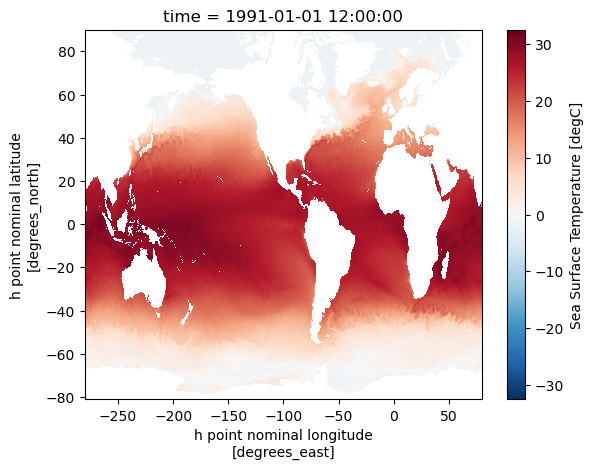

In [5]:
ds_gl['tos'].isel(time=0).plot()

In [6]:
ds_sample = ds_gl.sel(xh=slice(-150,-149.5), yh=slice(-40.5,-40)).chunk({'time':-1})
ds_sample

<xarray.Dataset>
Dimensions:     (xh: 5, yh: 7, time: 11588, nv: 2)
Coordinates:
  * xh          (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh          (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
  * time        (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv          (nv) float64 1.0 2.0
Data variables:
    zos         (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    sos         (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    tob         (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    sob         (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    mlotst      (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    speed       (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(11588,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(11588,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(11588,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(11588, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [7]:
tos = ds_sample['tos']
time_bnds = ds_sample['time_bnds']
ds = xr.combine_by_coords((tos, time_bnds))
ds

<xarray.Dataset>
Dimensions:    (time: 11588, nv: 2, xh: 5, yh: 7)
Coordinates:
  * time       (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv         (nv) float64 1.0 2.0
  * xh         (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh         (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
Data variables:
    time_bnds  (time, nv) timedelta64[ns] dask.array<chunksize=(11588, 2), meta=np.ndarray>
    tos        (time, yh, xh) float32 dask.array<chunksize=(11588, 7, 5), meta=np.ndarray>

In [8]:
from xmhw.xmhw import threshold

### Compare timing of xmhw and xcdat to compute climatology
The following will time the two approaches on the small subset of data above; i.e., 5 lon cells, 7 lat cells (total of 35 cells), with timing spanning 1991-01-01 $\Rightarrow$ 2022-09-01. We note that it is expected the xmhw will take longer due to calculating the 90th percentile threshold as well as the climatology. However we should still be able to assess the relative speed of the two methods. 

In [9]:
%%time
clim_xcdat = ds.temporal.climatology('tos','day')
clim_xcdat

CPU times: user 5.39 s, sys: 208 ms, total: 5.6 s
Wall time: 7.36 s


<xarray.Dataset>
Dimensions:  (nv: 2, xh: 5, yh: 7, time: 365)
Coordinates:
  * nv       (nv) float64 1.0 2.0
  * xh       (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh       (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Data variables:
    tos      (time, yh, xh) float64 dask.array<chunksize=(1, 7, 5), meta=np.ndarray>

In [9]:
sst = ds['tos']
datetimeindex = sst.indexes['time'].to_datetimeindex()

In [10]:
sst['time'] = datetimeindex

In [ ]:
%%time
clim_xmhw = threshold(sst, windowHalfWidth=0, smoothPercentile=False)
clim_xmhw

calendar not in keys


2023-02-06 10:15:46,628 [INFO]: core.py(handle_stream:877) >> Connection to tcp://127.0.0.1:48106 has been closed.
2023-02-06 10:15:46,633 [INFO]: scheduler.py(remove_worker:4795) >> Remove worker <WorkerState 'tcp://127.0.0.1:42083', name: 2, status: running, memory: 26, processing: 2>
2023-02-06 10:15:46,638 [INFO]: core.py(remove:1480) >> Removing comms to tcp://127.0.0.1:42083
2023-02-06 10:15:46,641 [INFO]: core.py(handle_stream:877) >> Connection to tcp://127.0.0.1:48104 has been closed.
2023-02-06 10:15:46,647 [INFO]: scheduler.py(remove_worker:4795) >> Remove worker <WorkerState 'tcp://127.0.0.1:35077', name: 3, status: running, memory: 27, processing: 2>
2023-02-06 10:15:46,648 [INFO]: core.py(remove:1480) >> Removing comms to tcp://127.0.0.1:35077
2023-02-06 10:15:46,651 [INFO]: core.py(handle_stream:877) >> Connection to tcp://127.0.0.1:48118 has been closed.
2023-02-06 10:15:46,652 [INFO]: scheduler.py(remove_worker:4795) >> Remove worker <WorkerState 'tcp://127.0.0.1:35885

In [59]:
%%time
ds = ds.load()
ds

CPU times: user 5.49 s, sys: 793 ms, total: 6.28 s
Wall time: 34.4 s


<xarray.Dataset>
Dimensions:    (time: 11588, nv: 2, xh: 5, yh: 7)
Coordinates:
  * time       (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv         (nv) float64 1.0 2.0
  * xh         (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh         (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
Data variables:
    time_bnds  (time, nv) timedelta64[ns] 0 days 1 days ... 11588 days
    tos        (time, yh, xh) float32 17.18 17.15 17.11 ... 11.73 11.71 11.69

In [60]:
%%time
test_sst = ds.temporal.climatology('tos','day')
test_sst

CPU times: user 1.49 s, sys: 120 ms, total: 1.61 s
Wall time: 1.46 s


<xarray.Dataset>
Dimensions:  (nv: 2, xh: 5, yh: 7, time: 365)
Coordinates:
  * nv       (nv) float64 1.0 2.0
  * xh       (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh       (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Data variables:
    tos      (time, yh, xh) float64 17.77 17.82 17.86 ... 18.78 18.85 18.91

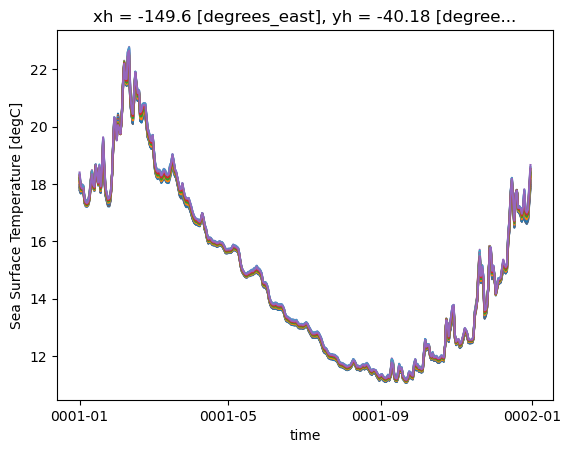

In [61]:
for i in range(5):
    for j in range(5):
        test_sst['tos'].isel(xh=i,yh=j).plot()
# test_sst['tos'].isel(xh=0,yh=0).plot()

In [62]:
from xmhw.xmhw import threshold

In [63]:
sst = ds['tos']
datetimeindex = sst.indexes['time'].to_datetimeindex()

In [64]:
sst['time'] = datetimeindex

In [65]:
sst_sub = sst[:,:2,:2]
sst_sub

<xarray.DataArray 'tos' (time: 11588, yh: 2, xh: 2)>
array([[[17.181654 , 17.15188  ],
        [17.179865 , 17.173397 ]],

       [[17.296844 , 17.260191 ],
        [17.281937 , 17.253572 ]],

       [[17.676226 , 17.595379 ],
        [17.607153 , 17.549278 ]],

       ...,

       [[11.4312935, 11.431453 ],
        [11.497538 , 11.510918 ]],

       [[11.585051 , 11.589682 ],
        [11.6508465, 11.661187 ]],

       [[11.456766 , 11.454374 ],
        [11.513891 , 11.514171 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2022-09-30T12:00:00
  * xh       (xh) float64 -150.0 -149.9
  * yh       (yh) float64 -40.49 -40.41
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [66]:
help(threshold)

Help on function threshold in module xmhw.xmhw:

threshold(temp, tdim='time', climatologyPeriod=[None, None], pctile=90, windowHalfWidth=5, smoothPercentile=True, smoothPercentileWidth=31, maxPadLength=None, coldSpells=False, tstep=False, anynans=False, skipna=False)
    Calculate threshold and mean climatology (day-of-year).
    
    Parameters
    ----------
    temp: xarray DataArray
        Temperature timeseries array
    tdim: str, optional
        Name of time dimension (default 'time')
    climatologyPeriod: list(int), optional
        Period over which climatology is calculated, specified as list
        of start and end years. Default is to use the full time series.
    pctile: int, optional
        Threshold percentile used to detect events (default=90)
    windowHalfWidth: int, optional
        Half width of window about day-of-year used for the pooling of
        values and calculation of threshold percentile (default=5)
    smoothPercentile: bool, optional
        If True

Comparing xmhw's windowHalfWidth to smoothPercentile...

In [76]:
xmhw_rawclim = threshold(sst_sub, windowHalfWidth=0, smoothPercentile=False)
xmhw_noWindow = threshold(sst_sub, windowHalfWidth=0, smoothPercentile=True)
xmhw_noSmooth_W5 = threshold(sst_sub, windowHalfWidth=5, smoothPercentile=False)
xmhw_default = threshold(sst_sub)

calendar not in keys
calendar not in keys
calendar not in keys
calendar not in keys


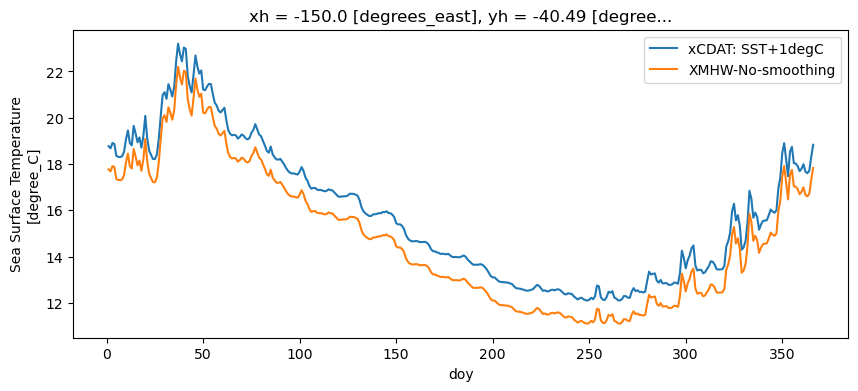

In [82]:
plt.figure(figsize=(10,4))
plt.plot(xmhw_clim.doy, clim_xcdat_1cell+1, label='xCDAT: SST+1degC')
xmhw_rawclim['seas'][:,0,0].plot(label='XMHW-No-smoothing')
plt.legend()

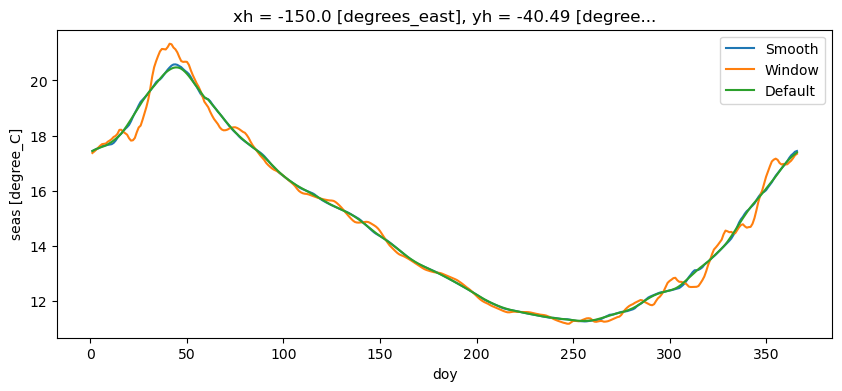

In [78]:
plt.figure(figsize=(10,4))
# xmhw_rawclim['seas'][:,0,0].plot(label='raw')
xmhw_noWindow['seas'][:,0,0].plot(label='Smooth')
xmhw_noSmooth_W5['seas'][:,0,0].plot(label='Window')
xmhw_default['seas'][:,0,0].plot(label='Default')
plt.legend()

Right so from this we can gather that the 11-day window without the smoothing reaches a much higher maximum temperature around summer time, whlist the combined 11-day window and 31-day smoothing is very similar to the 31-day smoothing. 

In [69]:
clim_xcdat = test_sst['tos']
clim_xcdat_1cell = clim_xcdat[:,0,0]


In [72]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

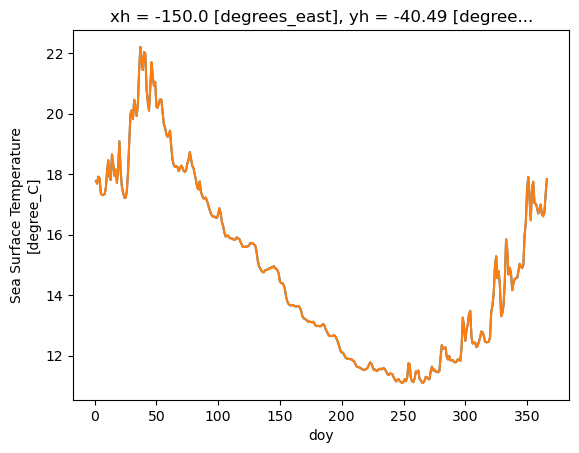

In [74]:
plt.figure()
plt.plot(xmhw_rawclim.doy, clim_xcdat_1cell)
xmhw_rawclim['seas'][:,0,0].plot()

In [49]:
xmhw_rawclim['seas'][:,0,0].plot()

<xarray.DataArray 'seas' (doy: 365)>
dask.array<getitem, shape=(365,), dtype=float32, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
    xh        float64 -150.0
    yh        float64 -40.49
    quantile  float64 0.9
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
Attributes:
    units:          degree_C
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [36]:
%%time
xmhw_clim = threshold(temp=sst_sub, windowHalfWidth=5, smoothPercentile=False)

calendar not in keys
CPU times: user 464 ms, sys: 68.5 ms, total: 532 ms
Wall time: 2.29 s


In [29]:
xmhw_clim0 = threshold(sst_sub, windowHalfWidth=0)

calendar not in keys


In [37]:
xmhw_clim5 = xmhw_clim

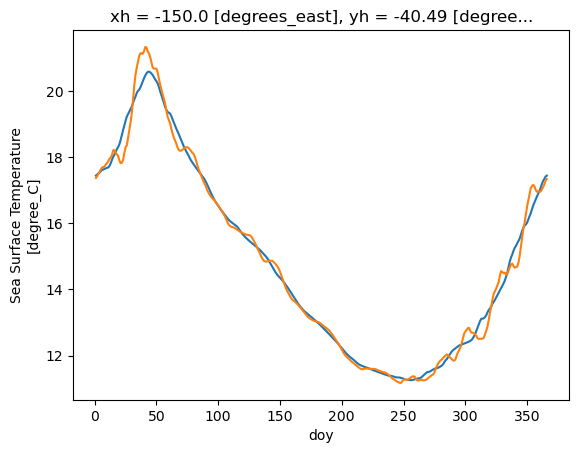

In [38]:
# test_sst['tos'][:,0,0].plot()
xmhw_clim0['seas'][:,0,0].plot()
xmhw_clim['seas'][:,0,0].plot()

In [28]:
test_sst['tos']

<xarray.DataArray 'tos' (time: 365, yh: 7, xh: 5)>
array([[[17.77125549, 17.8161335 , 17.85926247, 17.90904617,
         17.96133614],
        [17.88080406, 17.92640495, 17.96909332, 18.01939392,
         18.07252502],
        [17.99693298, 18.04134178, 18.09290695, 18.14177132,
         18.19317055],
        ...,
        [18.20710564, 18.25712204, 18.30512047, 18.35146904,
         18.40099335],
        [18.31460953, 18.3618679 , 18.40994453, 18.45678902,
         18.50388145],
        [18.41907883, 18.46570587, 18.5128746 , 18.55969048,
         18.60460663]],

       [[17.68113327, 17.6795845 , 17.67811012, 17.67532158,
         17.67243004],
        [17.75301552, 17.75429916, 17.74824905, 17.73704147,
         17.73835564],
        [17.82972908, 17.83109856, 17.82414436, 17.8114872 ,
         17.81238365],
...
        [17.75089836, 17.80335045, 17.8527565 , 17.91050911,
         17.96321106],
        [17.86914635, 17.92152977, 17.97083092, 18.03936005,
         18.08279037],
        [17.98855591, 18.0460968 , 18.10450745, 18.16206741,
         18.21160698]],

       [[17.83063889, 17.89802551, 17.9671402 , 18.04679489,
         18.12055779],
        [17.96081734, 18.030159  , 18.10394478, 18.18529129,
         18.25867462],
        [18.09884262, 18.17097282, 18.25324059, 18.32947731,
         18.40195656],
        ...,
        [18.36061478, 18.44092369, 18.51327324, 18.58774757,
         18.66101074],
        [18.49404716, 18.57258415, 18.64678192, 18.72138405,
         18.7906723 ],
        [18.62312698, 18.70271301, 18.77923775, 18.85196877,
         18.91121864]]])
Coordinates:
  * xh       (xh) float64 -150.0 -149.9 -149.8 -149.7 -149.6
  * yh       (yh) float64 -40.49 -40.41 -40.34 -40.26 -40.18 -40.11 -40.03
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature
    operation:      temporal_avg
    mode:           climatology
    freq:           day
    weighted:       True

In [52]:
help(threshold)

Help on function threshold in module xmhw.xmhw:

threshold(temp, tdim='time', climatologyPeriod=[None, None], pctile=90, windowHalfWidth=5, smoothPercentile=True, smoothPercentileWidth=31, maxPadLength=None, coldSpells=False, tstep=False, anynans=False, skipna=False)
    Calculate threshold and mean climatology (day-of-year).
    
    Parameters
    ----------
    temp: xarray DataArray
        Temperature timeseries array
    tdim: str, optional
        Name of time dimension (default 'time')
    climatologyPeriod: list(int), optional
        Period over which climatology is calculated, specified as list
        of start and end years. Default is to use the full time series.
    pctile: int, optional
        Threshold percentile used to detect events (default=90)
    windowHalfWidth: int, optional
        Half width of window about day-of-year used for the pooling of
        values and calculation of threshold percentile (default=5)
    smoothPercentile: bool, optional
        If True

In [40]:
test_depart = ds.temporal.departures('tos', 'month')

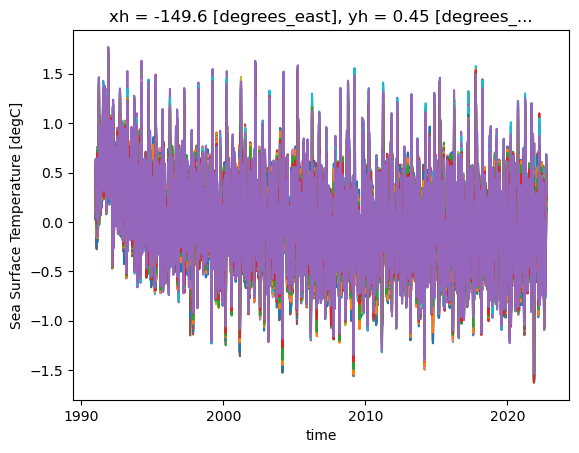

In [41]:
for i in range(5):
    for j in range(5):
        test_depart['tos'].isel(xh=i,yh=j).plot()
# test_sst['tos'].isel(xh=0,yh=0).plot()

In [21]:
%%time
clim = ds.temporal.climatology('tos','day')
clim

CPU times: user 1.92 s, sys: 136 ms, total: 2.06 s
Wall time: 1.91 s


<xarray.Dataset>
Dimensions:  (nv: 2, xh: 2, yh: 2, time: 365)
Coordinates:
  * nv       (nv) float64 1.0 2.0
  * xh       (xh) float64 -279.9 -279.8
  * yh       (yh) float64 -81.11 -81.07
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Data variables:
    tos      (time, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan

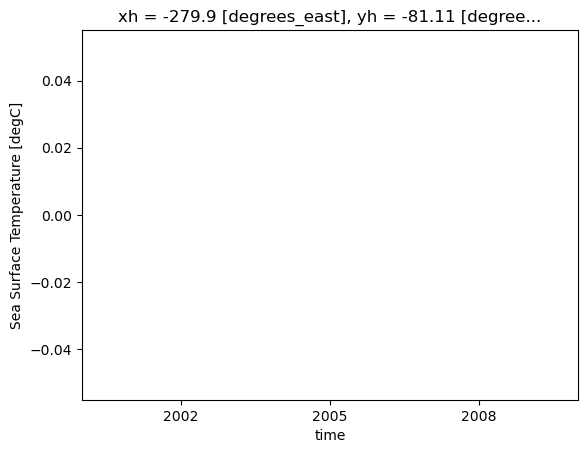

In [23]:
clim['tos'].isel(xh=0,yh=0).plot()

In [6]:
%%time
test = ds_gl_sub.temporal.climatology('tos','day')

2023-02-02 15:39:55,751 [INFO]: core.py(_measure_tick:595) >> Event loop was unresponsive in Nanny for 3.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


CPU times: user 6.76 s, sys: 998 ms, total: 7.75 s
Wall time: 10.5 s


2023-02-02 15:39:55,776 [INFO]: core.py(_measure_tick:595) >> Event loop was unresponsive in Scheduler for 3.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [11]:
%%time
tos = test.tos.chunk({'time':-1})
tos = tos.load()
tos

2023-02-02 15:42:32,018 [INFO]: core.py(_measure_tick:595) >> Event loop was unresponsive in Nanny for 3.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-02-02 15:42:32,021 [INFO]: core.py(_measure_tick:595) >> Event loop was unresponsive in Scheduler for 3.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-02-02 15:44:19,053 [INFO]: core.py(handle_stream:877) >> Connection to tcp://127.0.0.1:58804 has been closed.
2023-02-02 15:44:19,088 [INFO]: scheduler.py(remove_worker:4775) >> Remove worker <WorkerState 'tcp://127.0.0.1:45651', name: 1, status: running, memory: 853, processing: 2>
2023-02-02 15:44:19,127 [INFO]: core.py(remove:1480) >> Removing comms to tcp://127.0.0.1:45651


KeyboardInterrupt: 

2023-02-02 15:44:19,412 [INFO]: scheduler.py(remove_worker:4855) >> Lost all workers
2023-02-02 15:44:20,924 [INFO]: nanny.py(mark_stopped:761) >> Worker process 316818 was killed by signal 15
2023-02-02 15:44:20,931 [INFO]: nanny.py(close_gracefully:569) >> Closing Nanny gracefully at 'tcp://127.0.0.1:34749'. Reason: worker-close
2023-02-02 15:44:20,936 [INFO]: nanny.py(close:587) >> Closing Nanny at 'tcp://127.0.0.1:34749'. Reason: nanny-close-gracefully
2023-02-02 15:44:20,942 [INFO]: scheduler.py(close:3923) >> Scheduler closing...
2023-02-02 15:44:20,945 [INFO]: scheduler.py(close:3945) >> Scheduler closing all comms
Exception ignored in: <coroutine object ServerSession.with_document_locked at 0x1513252fdac0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/bokeh/server/session.py", line 107, in _needs_document_lock_wrapper
    await p
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/p

In [ ]:
tos[:,0].plot()

In [ ]:
%%time
sst_test = test.tos.load()
sst_test

In [ ]:
sst_test[:,0,0].plot()

In [8]:
ds_gl.time_bnds

<xarray.DataArray 'time_bnds' (time: 11588, nv: 2)>
dask.array<concatenate, shape=(11588, 2), dtype=timedelta64[ns], chunksize=(92, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv       (nv) float64 1.0 2.0
Attributes:
    long_name:  time axis boundaries
    calendar:   noleap

In [9]:
# MOM6-Regional path
mom_rg = '/g/data/ul08/MOM6/mom6_eac_output/mom6_eac_long_orlanksi/'
variable = 'tos' # surface temp
path_key = 'output*/*.ocean_daily.nc'

ds_path = glob.glob(mom_rg + path_key)
ds_path.sort()

# ds_rg = xr.open_mfdataset(ds_path)

# da_rg = ds_rg[variable]
# da_rg


In [5]:
%%time
n_files = 30
blocks = len(ds_path) // n_files
tos_list = []

for i in range(blocks):
    f_from = i*n_files # file from
    f_to = (i+1)*n_files # file to
    da = xr.open_mfdataset(ds_path[f_from:f_to])['tos']
    da.to_netcdf(f'/g/data/v45/jr5971/notebooks/data/mom6-eac_cc-orlansk_sst-chunk-{i}.nc')
    print(f'opened block {i+1} of {blocks}')
    tos_list.append(da)
    print(f'length of list is now {len(tos_list)}')
    del(da)

opened block 1 of 12
length of list is now 1
opened block 2 of 12
length of list is now 2
opened block 3 of 12
length of list is now 3
opened block 4 of 12
length of list is now 4
opened block 5 of 12
length of list is now 5
opened block 6 of 12
length of list is now 6
opened block 7 of 12
length of list is now 7
opened block 8 of 12
length of list is now 8
opened block 9 of 12
length of list is now 9
opened block 10 of 12
length of list is now 10
opened block 11 of 12
length of list is now 11
opened block 12 of 12
length of list is now 12
CPU times: user 2min 15s, sys: 32 s, total: 2min 47s
Wall time: 27min 39s


In [5]:
da_list = glob.glob('/g/data/v45/jr5971/notebooks/data/mom6*')

ds_rg = xr.open_mfdataset(da_list)
ds_rg

<xarray.Dataset>
Dimensions:  (xh: 320, yh: 490, time: 10950)
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.2 -184.1 -184.0
  * yh       (yh) float64 -48.06 -47.99 -47.93 -47.86 ... -6.238 -6.138 -6.039
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Data variables:
    tos      (time, yh, xh) float32 dask.array<chunksize=(911, 490, 320), meta=np.ndarray>

Now we have the sea surface temperature for both experiments we can start looking at plotting some SST figures to understand how they differ. What about just dividing the domain roughly into different regions. Taking averages over those regions and seeing how they look?

Say, a couple of coastal regions, eac jet, eac separation, and eac east/south extension regions as well as some further out into the quiescent region close to NZ. 

How would we do this - perhaps make a map, then draw lines where we are going to divide the map into the different sections. I've surely got some code that can do this relatively easily. 

In [6]:
import matplotlib.patches as patches

# domain limits
coords = {'W':np.round(ds_rg.xh[0].values,2), 'E':np.round(ds_rg.xh[-1].values,2), 
          'N':np.round(ds_rg.yh[-1].values,2), 'S':np.round(ds_rg.yh[0].values,2)}
coords

{'W': -215.95, 'E': -184.05, 'N': -6.04, 'S': -48.06}

In [7]:
ds_gl

<xarray.Dataset>
Dimensions:     (xh: 3600, yh: 2700, time: 11588, nv: 2)
Coordinates:
  * xh          (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh          (yh) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * time        (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv          (nv) float64 1.0 2.0
Data variables:
    zos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    sos         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    tob         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    sob         (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    mlotst      (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    speed       (time, yh, xh) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [8]:
ds_glo_tas = ds_gl.sel(xh=slice(coords['W'],coords['E']),yh=slice(coords['S'],coords['N']))
ds_glo_tas

<xarray.Dataset>
Dimensions:     (xh: 319, yh: 488, time: 11588, nv: 2)
Coordinates:
  * xh          (xh) float64 -215.9 -215.8 -215.7 ... -184.3 -184.2 -184.1
  * yh          (yh) float64 -47.99 -47.93 -47.86 ... -6.337 -6.238 -6.138
  * time        (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv          (nv) float64 1.0 2.0
Data variables:
    zos         (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    sos         (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    tob         (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    sob         (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    mlotst      (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    speed       (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [9]:
ds_gl_tas_sub = ds_glo_tas.drop_vars(['zos','sos','tob','sob','mlotst','speed','average_T1',
                                      'average_T2','average_DT'])
ds_gl_tas_sub

<xarray.Dataset>
Dimensions:    (xh: 319, yh: 488, time: 11588, nv: 2)
Coordinates:
  * xh         (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh         (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -6.337 -6.238 -6.138
  * time       (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv         (nv) float64 1.0 2.0
Data variables:
    tos        (time, yh, xh) float32 dask.array<chunksize=(90, 488, 319), meta=np.ndarray>
    time_bnds  (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [10]:
ds_gl_tas_sub.nbytes/1e6

7215.993128

Let's save this dataset as individual chunks

In [11]:
test = ds_gl_tas_sub.chunk({'time':-1,'xh':-1,'yh':10})
test

<xarray.Dataset>
Dimensions:    (xh: 319, yh: 488, time: 11588, nv: 2)
Coordinates:
  * xh         (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh         (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -6.337 -6.238 -6.138
  * time       (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
  * nv         (nv) float64 1.0 2.0
Data variables:
    tos        (time, yh, xh) float32 dask.array<chunksize=(11588, 10, 319), meta=np.ndarray>
    time_bnds  (time, nv) timedelta64[ns] dask.array<chunksize=(11588, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [12]:
tos = test.tos
tos

<xarray.DataArray 'tos' (time: 11588, yh: 488, xh: 319)>
dask.array<rechunk-merge, shape=(11588, 488, 319), dtype=float32, chunksize=(11588, 10, 319), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh       (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -6.337 -6.238 -6.138
  * time     (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [13]:
_, yh, xh = tos.chunks
xhstep = xh[0]
yhstep = yh[0]
xhblocks = len(xh)
yhblocks = len(yh)
print(f'{xhstep}, {yhstep}, {xhblocks}, {yhblocks}')

319, 10, 1, 49


In [14]:
%%time
dat_chunk1 = tos.isel(xh=slice(0,xhstep), yh=slice(0,yhstep))
dat_chunk1 = dat_chunk1.load()
dat_chunk1

CPU times: user 23.3 s, sys: 3.46 s, total: 26.8 s
Wall time: 4min 4s


<xarray.DataArray 'tos' (time: 11588, yh: 10, xh: 319)>
array([[[10.598019 , 10.646118 , 10.681453 , ..., 11.564525 ,
         11.640321 , 11.778795 ],
        [10.674286 , 10.711084 , 10.749418 , ..., 11.647759 ,
         11.730612 , 11.8453455],
        [10.749642 , 10.783542 , 10.80735  , ..., 11.746873 ,
         11.808079 , 11.903226 ],
        ...,
        [10.982031 , 10.984564 , 10.979184 , ..., 12.015738 ,
         12.030902 , 12.055887 ],
        [11.005173 , 11.004287 , 11.014455 , ..., 12.065828 ,
         12.1025095, 12.166514 ],
        [11.030447 , 11.037346 , 11.038379 , ..., 12.18874  ,
         12.298854 , 12.438858 ]],

       [[10.723302 , 10.7678585, 10.807564 , ..., 11.283744 ,
         11.326624 , 11.436352 ],
        [10.794156 , 10.836889 , 10.873467 , ..., 11.358675 ,
         11.412104 , 11.510082 ],
        [10.871577 , 10.907987 , 10.935496 , ..., 11.451646 ,
         11.487403 , 11.576865 ],
...
        [10.27829  , 10.154935 ,  9.941733 , ...,  9.764799 ,
          9.752337 ,  9.7391205],
        [10.28737  , 10.201628 ,  9.975634 , ...,  9.772903 ,
          9.763366 ,  9.751995 ],
        [10.2919855, 10.249659 , 10.049642 , ...,  9.77115  ,
          9.754894 ,  9.744896 ]],

       [[10.265483 , 10.219028 , 10.154837 , ...,  9.298916 ,
          9.305029 ,  9.288881 ],
        [10.246541 , 10.182776 , 10.0690155, ...,  9.345876 ,
          9.363626 ,  9.366312 ],
        [10.236871 , 10.14057  ,  9.938933 , ...,  9.44982  ,
          9.425894 ,  9.4032755],
        ...,
        [10.227082 , 10.0886   ,  9.886825 , ...,  9.836076 ,
          9.8206625,  9.807249 ],
        [10.240461 , 10.13674  ,  9.889084 , ...,  9.843438 ,
          9.825815 ,  9.81757  ],
        [10.246992 , 10.195829 ,  9.941653 , ...,  9.834557 ,
          9.819492 ,  9.8055525]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh       (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -47.52 -47.46 -47.39
  * time     (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [15]:
%%time
dat_chunk1.to_netcdf('/g/data/v45/jr5971/notebooks/data/mom6-global/tas_chunk1.nc')

CPU times: user 4.77 s, sys: 310 ms, total: 5.08 s
Wall time: 4.6 s


In [16]:
%%time
for i in range(xhblocks):
    xh_from = i*xhstep
    xh_to = (i+1)*xhstep
    for j in range(yhblocks):
        print(f'loading chunk {i+j} of {yhblocks}')
        yh_from = j*yhstep
        yh_to = (j+1)*yhstep
        sst = tos.isel(xh=slice(xh_from,xh_to),yh=slice(yh_from,yh_to)).load()
        print(f'chunk number {i+j} loaded')
        sst.to_netcdf(f'/g/data/v45/jr5971/notebooks/data/mom6-global/tas_sst.xh-{i}.yh-{j}.nc')
        print(f'and now saved')
        del(sst)

loading chunk 0 of 49
chunk number 0 loaded
and now saved
loading chunk 1 of 49
chunk number 1 loaded
and now saved
loading chunk 2 of 49
chunk number 2 loaded
and now saved
loading chunk 3 of 49
chunk number 3 loaded
and now saved
loading chunk 4 of 49
chunk number 4 loaded
and now saved
loading chunk 5 of 49
chunk number 5 loaded
and now saved
loading chunk 6 of 49
chunk number 6 loaded
and now saved
loading chunk 7 of 49
chunk number 7 loaded
and now saved
loading chunk 8 of 49
chunk number 8 loaded
and now saved
loading chunk 9 of 49
chunk number 9 loaded
and now saved
loading chunk 10 of 49
chunk number 10 loaded
and now saved
loading chunk 11 of 49
chunk number 11 loaded
and now saved
loading chunk 12 of 49
chunk number 12 loaded
and now saved
loading chunk 13 of 49
chunk number 13 loaded
and now saved
loading chunk 14 of 49
chunk number 14 loaded
and now saved
loading chunk 15 of 49
chunk number 15 loaded
and now saved
loading chunk 16 of 49
chunk number 16 loaded
and now saved


Then, once this data is saved, we also save the time_bounds as its own dataset, and then attempt to calculate daily climatologies again. 

Then hopefully we can add the time_bounds to the regional sst dataset to calculate climatologies for this one as well. 

- From there we can look at whether the climatologies are the same across the domain, and whether the variability is similar as well. For example, do both models show the same climatological temperatures over a region? We would hope that this is the case. Before actually calculating climatologies however, we should first identify the spin-up period for both models as this is not to be included in the analysis. How best to identify the spin-up period?

- I need to highlight that what I'm doing is best practice - sometimes I think I'm just taking up extra space for no reason, however in order to load in some temperature data for a specific region, from the raw MOM6 output, we'd have to load in 100s of netcdf files, with a bunch of other data variables included, just to select the sst from that file - this isn't entirely correct as the file is loaded in "lazily", i.e., only the metadata is read to memory. But still I'm not entirely sure how else to get around this problem. 

In [19]:
ds_gl_tas_sub.tos.chunk({'time':-1,'yh':'auto','xh':'auto'})
# ds_gl_tas_sub.tos

<xarray.DataArray 'tos' (time: 11588, yh: 488, xh: 319)>
dask.array<rechunk-merge, shape=(11588, 488, 319), dtype=float32, chunksize=(11588, 66, 43), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh       (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -6.337 -6.238 -6.138
  * time     (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

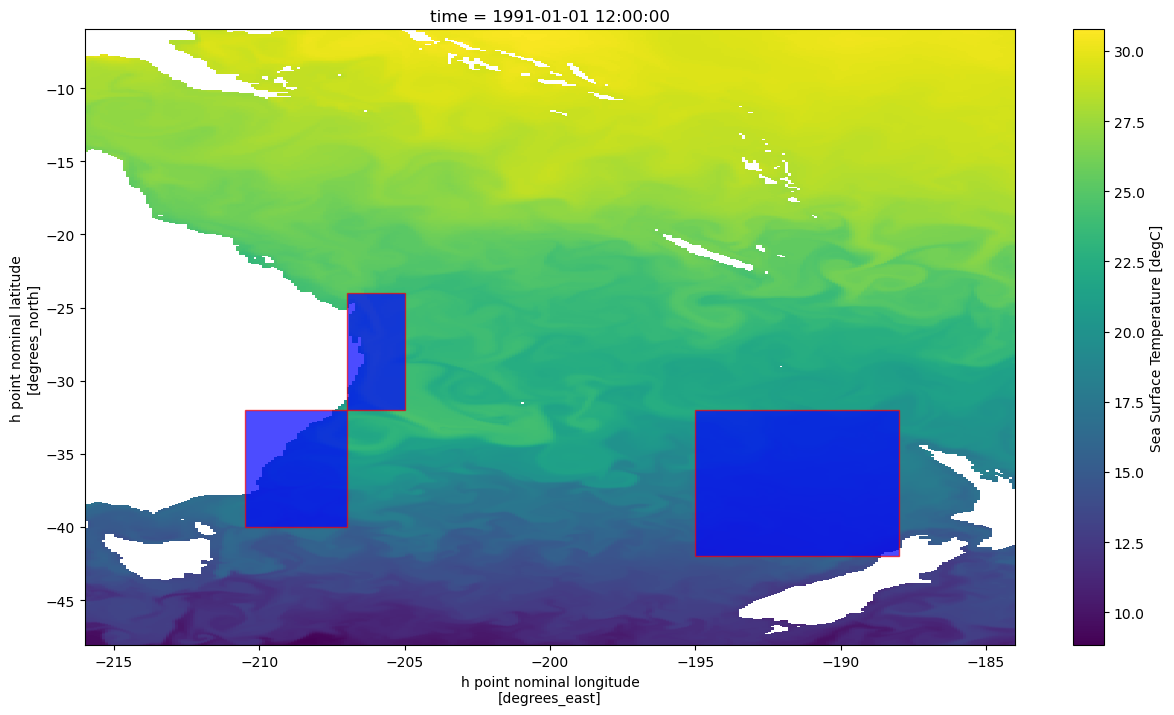

In [41]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.pcolormesh(da_rg.xh, da_rg.yh, da_rg[0,:100,:100])
da_rg[0,:,:].plot(ax=ax)

# Create boxes
sth_ext = {'W':-210.5,'E':-207,'N':-32,'S':-40}
eac_jet = {'W':-207,'E':-205,'N':-24,'S':-32}
east_tas = {'W':-195,'E':-188,'N':-32,'S':-42}
boxes = [sth_ext, eac_jet, east_tas]

for box in boxes:
    rect = patches.Rectangle((box['W'],box['S']),(box['E']-box['W']),(box['N']-box['S']),
                          transform=ax.transData, linewidth=1, edgecolor='r',
                          facecolor='blue', alpha=0.7)
    ax.add_patch(rect)

plt.show()

Right, so we'll start with these three boxes. Let's take some summary statistics, and perhaps plot some time series, and histograms maybe of SST over these three regions for both experiments and then we can further understand a few things about spin-up etc. 

Now, I want to make an xarray dataset that selects all the SST data for each of these boxes individually and saves these in separate data arrays in the dataset. The dataset will be called reg_sst (regional SST), and each data array will have the coordinates associated with the particular region. 

In [ ]:
reg_sst = xr.Dataset(
    data_vars = dict(
        eac_jet = (['xh','yh','time'],da_rg

In [70]:
# da_gl_tas = da_gl.sel(yh=slice(coords['S'],coords['N']),
#                       xh=slice(coords['W'],coords['E']))
# da_rg = da_rg.sel(yh=slice(coords['S'],coords['N']),
#                       xh=slice(coords['W'],coords['E']))
# gl_eac = da_gl.sel(yh=slice(eac_jet['S'],eac_jet['N']),
#                    xh=slice(eac_jet['W'],eac_jet['E']))
# gl_sst = {}
# rg_sst = {}

ds_reg = xr.Dataset()
ds_glo = xr.Dataset()
box_names = ['sth_ext','eac_jet','east_tas']
for box_name,box in zip(box_names,boxes):
    # mom6-regional
    da = da_rg.sel(yh=slice(box['S'],box['N']),
                   xh=slice(box['W'],box['E']))
    ds_reg[box_name] = da
    
    # mom6-global
    da = da_gl.sel(yh=slice(box['S'],box['N']),
                   xh=slice(box['W'],box['E']))
    ds_glo[box_name] = da
    
    
    
    
    # gl_sst[f'{box}'] = da_gl.sel(yh=slice(box['S'],box['N']),
    #                             xh=slice(box['W'],box['E']))
    # rg_sst[f'{box}'] = da_rg.sel(yh=slice(box['S'],box['N']),
                                # xh=slice(box['W'],box['E']))
    

In [71]:
ds_glo

<xarray.Dataset>
Dimensions:   (xh: 35, yh: 99, time: 11588)
Coordinates:
  * xh        (xh) float64 -210.4 -210.3 -210.2 -210.1 ... -207.2 -207.1 -207.0
  * yh        (yh) float64 -39.95 -39.88 -39.8 -39.72 ... -32.21 -32.12 -32.04
  * time      (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
Data variables:
    sth_ext   (time, yh, xh) float32 dask.array<chunksize=(90, 99, 35), meta=np.ndarray>
    eac_jet   (time, yh, xh) float32 dask.array<chunksize=(90, 99, 35), meta=np.ndarray>
    east_tas  (time, yh, xh) float32 dask.array<chunksize=(90, 99, 35), meta=np.ndarray>

In [68]:
sth_ext = ds.sth_ext

In [72]:
import xcdat

In [83]:
ds_reg

<xarray.Dataset>
Dimensions:   (xh: 35, yh: 99, time: 10950)
Coordinates:
  * xh        (xh) float64 -210.4 -210.3 -210.2 -210.1 ... -207.2 -207.1 -207.0
  * yh        (yh) float64 -39.95 -39.88 -39.8 -39.72 ... -32.21 -32.12 -32.04
  * time      (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Data variables:
    sth_ext   (time, yh, xh) float32 dask.array<chunksize=(911, 99, 35), meta=np.ndarray>
    eac_jet   (time, yh, xh) float32 dask.array<chunksize=(911, 99, 35), meta=np.ndarray>
    east_tas  (time, yh, xh) float32 dask.array<chunksize=(911, 99, 35), meta=np.ndarray>

In [18]:
attrs = ds_rg.time.attrs
attrs

{'long_name': 'time',
 'axis': 'T',
 'calendar_type': 'NOLEAP',
 'bounds': 'time_bnds'}

In [20]:
ds_rg.tos.

<xarray.DataArray 'tos' (time: 10950, yh: 490, xh: 320)>
dask.array<concatenate, shape=(10950, 490, 320), dtype=float32, chunksize=(914, 490, 320), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.2 -184.1 -184.0
  * yh       (yh) float64 -48.06 -47.99 -47.93 -47.86 ... -6.238 -6.138 -6.039
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [97]:
del attrs['bounds']
attrs

KeyError: 'bounds'

In [93]:
attrs

{'long_name': 'time', 'axis': 'T', 'calendar_type': 'NOLEAP'}

In [99]:
ds_reg.sth_ext.time

<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(1991, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1991, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1991, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP

In [101]:
test = ds_glo.temporal.climatology('sth_ext','day')

KeyError: 'time_bnds'

In [100]:
da_clim = ds_reg.temporal.climatology(
    'sth_ext',
    'day'
)

KeyError: "No bounds were found for the 'T' axis. Make sure bounds vars exist in the Dataset with names that match the 'bounds' keys, or try adding bounds."

In [73]:
da_daily_clim = sth_ext_mean.temporal.climatology(
    'tos',
    'daily'
)

AttributeError: 'DataArray' object has no attribute 'temporal'

In [76]:
ds_test = sth_ext_mean.to_dataset()
ds_test

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Data variables:
    sth_ext  (time) float32 dask.array<chunksize=(911,), meta=np.ndarray>

In [82]:
sth_ext_mean

<xarray.DataArray 'sth_ext' (time: 10950)>
dask.array<mean_agg-aggregate, shape=(10950,), dtype=float32, chunksize=(914,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00

In [77]:
d_clim_test = ds_test.temporal.climatology("sth_ext",freq="day",weighted=True)

KeyError: 'time_bnds'

In [ ]:
xcdat.dataset.

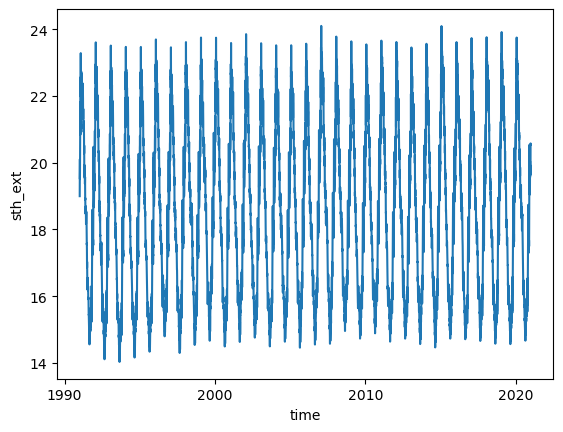

In [69]:
sth_ext_mean = sth_ext.mean(dim=('xh','yh'))
sth_clim = sth_ext_mean.mean
sth_ext_mean.plot()

In [56]:
gl_sst

{"{'W': -210.5, 'E': -207, 'N': -32, 'S': -40}": <xarray.DataArray 'tos' (time: 11588, yh: 99, xh: 35)>
 dask.array<getitem, shape=(11588, 99, 35), dtype=float32, chunksize=(92, 99, 35), chunktype=numpy.ndarray>
 Coordinates:
   * xh       (xh) float64 -210.4 -210.3 -210.2 -210.1 ... -207.2 -207.1 -207.0
   * yh       (yh) float64 -39.95 -39.88 -39.8 -39.72 ... -32.21 -32.12 -32.04
   * time     (time) object 1991-01-01 12:00:00 ... 2022-09-30 12:00:00
 Attributes:
     units:          degC
     long_name:      Sea Surface Temperature
     cell_methods:   area:mean yh:mean xh:mean time: mean
     cell_measures:  area: areacello
     time_avg_info:  average_T1,average_T2,average_DT
     standard_name:  sea_surface_temperature,
 "{'W': -207, 'E': -205, 'N': -24, 'S': -32}": <xarray.DataArray 'tos' (time: 11588, yh: 91, xh: 20)>
 dask.array<getitem, shape=(11588, 91, 20), dtype=float32, chunksize=(92, 91, 20), chunktype=numpy.ndarray>
 Coordinates:
   * xh       (xh) float64 -206.9 -206.8

In [47]:
da_rg

<xarray.DataArray 'tos' (time: 10950, yh: 488, xh: 319)>
dask.array<getitem, shape=(10950, 488, 319), dtype=float32, chunksize=(914, 488, 319), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -215.9 -215.8 -215.7 -215.6 ... -184.3 -184.2 -184.1
  * yh       (yh) float64 -47.99 -47.93 -47.86 -47.79 ... -6.337 -6.238 -6.138
  * time     (time) object 1991-01-01 12:00:00 ... 2020-12-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature